In [81]:
import torch
import os
from torch.utils.data import TensorDataset,ConcatDataset,DataLoader,WeightedRandomSampler
import matplotlib.pyplot as plt
from torch import nn
from torch.nn.functional import relu
from tqdm import tqdm
import seaborn as sns

device = 'mps'
path_to_pt_ekyn = f'../../sleep/pt_ekyn'

In [82]:
recording_filenames = os.listdir(path_to_pt_ekyn)
id = recording_filenames[0]
print(id)
X,y = torch.load(f'{path_to_pt_ekyn}/{id}')

X = X.unsqueeze(1)
X = X[:,:,::10] # 500 Hz -> 50 Hz

weighted = True

if weighted:
    dataset = TensorDataset(X,y)
    labels = torch.tensor([data[1].argmax().item() for data in dataset])
    class_counts = torch.bincount(labels)
    class_weights = 1. / class_counts.float()
    weights = class_weights[labels]
    trainloader = DataLoader(dataset, batch_size=512, sampler=WeightedRandomSampler(weights, num_samples=len(weights), replacement=True))
else:
    trainloader = DataLoader(TensorDataset(X,y),batch_size=512,shuffle=True)

Xi,yi = next(iter(trainloader))
print(Xi.shape,yi.shape,yi.argmax(dim=1).bincount())

C4-0_PF.pt
torch.Size([512, 1, 500]) torch.Size([512, 3]) tensor([163, 150, 199])


In [83]:
class SimpleNorm(nn.Module):
    def __init__(self,eps):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.tensor(1.0))
        self.shift = nn.Parameter(torch.tensor(0.0))
    def forward(self,x):
        mean = x.flatten().mean()
        std = x.flatten().std()
        x = (x - mean) / (std + self.eps)
        return x * self.scale + self.shift
    
class CNNSleepStager(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.norm = SimpleNorm(1e-5)
        self.c1 = nn.Conv1d(in_channels=1,out_channels=64,kernel_size=7)
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(in_features=64,out_features=3)
    def forward(self,x):
        x = self.norm(x)
        x = self.c1(x)
        x = relu(x)
        x = self.gap(x)
        x = x.squeeze()
        x = self.classifier(x)
        return x
    
model = CNNSleepStager()
optimizer = torch.optim.AdamW(model.parameters(),lr=3e-3)
criterion = nn.CrossEntropyLoss()
model.to(device)

CNNSleepStager(
  (norm): SimpleNorm()
  (c1): Conv1d(1, 64, kernel_size=(7,), stride=(1,))
  (gap): AdaptiveAvgPool1d(output_size=1)
  (classifier): Linear(in_features=64, out_features=3, bias=True)
)

100%|██████████| 500/500 [01:53<00:00,  4.42it/s]


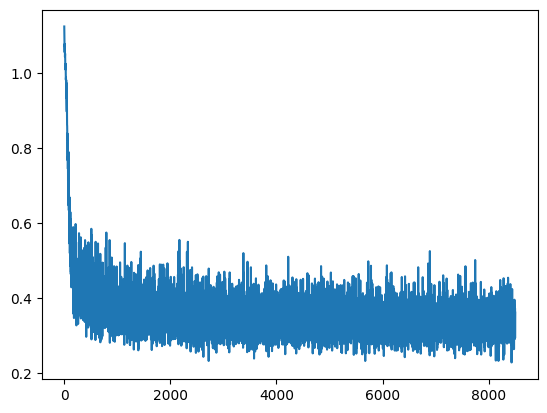

In [84]:
lossi = []

for epoch in tqdm(range(500)):
    for Xi,yi in trainloader:
        Xi,yi = Xi.to(device),yi.to(device)
        optimizer.zero_grad()
        logits = model(Xi)
        loss = criterion(logits,yi)
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
plt.plot(lossi)

C4-0_PF.pt
              precision    recall  f1-score   support

           0       0.50      0.86      0.63       472
           1       0.97      0.85      0.90      4189
           2       0.85      0.89      0.87      3979

    accuracy                           0.87      8640
   macro avg       0.77      0.87      0.80      8640
weighted avg       0.89      0.87      0.87      8640



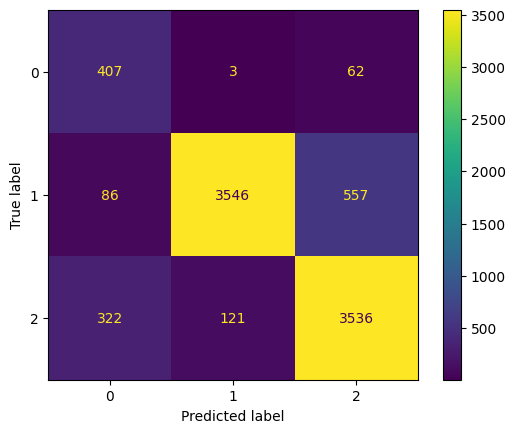

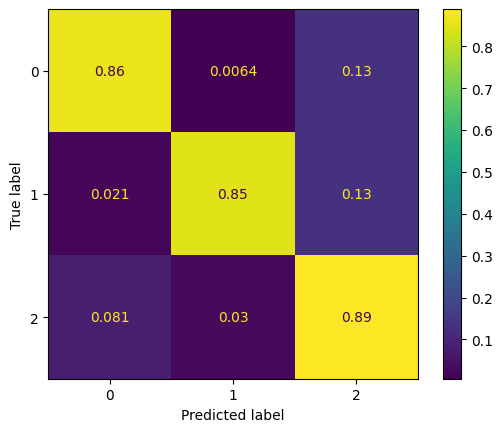

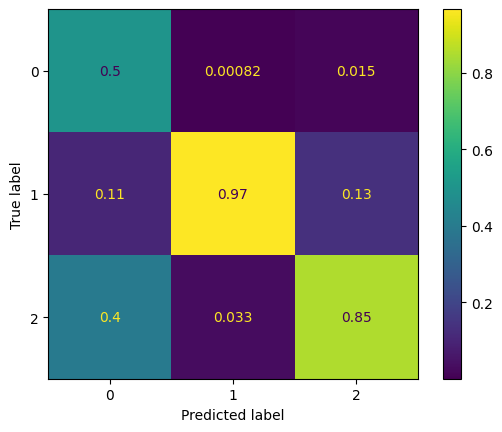

In [85]:
recording_filenames = os.listdir(path_to_pt_ekyn)
id = recording_filenames[0]
print(id)
X,y = torch.load(f'{path_to_pt_ekyn}/{id}')
X = X.unsqueeze(1)
X = X[:,:,::10] # 500 Hz -> 50 Hz

trainloader = DataLoader(TensorDataset(X,y),batch_size=512,shuffle=False)

y = torch.vstack([torch.vstack([model(Xi.to(device)).softmax(dim=1).argmax(dim=1).cpu(),yi.argmax(dim=1)]).T for Xi,yi in trainloader])
y_pred = y[:,0]
y_true = y[:,1]

from sklearn.metrics import ConfusionMatrixDisplay,classification_report
ConfusionMatrixDisplay.from_predictions(y_true=y_true,y_pred=y_pred)
ConfusionMatrixDisplay.from_predictions(y_true=y_true,y_pred=y_pred,normalize='true')
ConfusionMatrixDisplay.from_predictions(y_true=y_true,y_pred=y_pred,normalize='pred')

print(classification_report(y_true=y_true,y_pred=y_pred))

C4-0_PF.pt


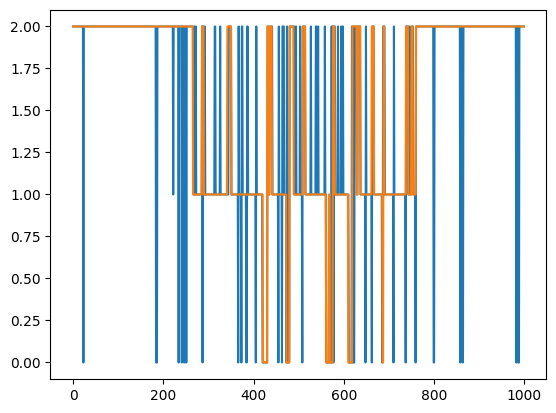

In [86]:
recording_filenames = os.listdir(path_to_pt_ekyn)
id = recording_filenames[0]
print(id)
X,y = torch.load(f'{path_to_pt_ekyn}/{id}')
X = X.unsqueeze(1)
X = X[:,:,::10] # 500 Hz -> 50 Hz
testloader = DataLoader(TensorDataset(X,y),batch_size=512,shuffle=False)

y = torch.vstack([torch.vstack([model(Xi.to(device)).softmax(dim=1).argmax(dim=1).cpu(),yi.argmax(dim=1)]).T for Xi,yi in testloader])
y_pred = y[:,0]
y_true = y[:,1]

plt.plot(y_pred[:1000])
plt.plot(y_true[:1000])